In [1]:
import numpy as np
import glob
import os
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc

%matplotlib inline

## Preparing dataset
### Load and split files by classes

In [2]:
path = os.getcwd() + '/vowels'

VOWELS = glob.glob(path + '/*.wav')
assert len(VOWELS) > 0, ".wav files not found in " + path + " ! Please check the path"

FILES = {
    'natural_male': glob.glob(path + '/nam*.wav'),
    'natural_female': glob.glob(path + '/naf*.wav'),
    'natural_kid': glob.glob(path + '/nk*.wav'),
    'synth_male': glob.glob(path + '/sam*.wav'),
    'synth_female': glob.glob(path + '/saf*.wav'),
    'synth_kid': glob.glob(path + '/sk*.wav')
}

# number of coefficients used
MFCC_COEFFS = 13

### MFCC computation

In [3]:
def read_wav_files(files):
    """
    Get the sample rate and all data for each files
    :param files: an array of file paths (must be .wav files)
    :return: (rates, data)
    """
    n = len(files)
    data = []
    rates = np.zeros(n)
    for i in xrange(len(files)):
        rate, d = wav.read(files[i])
        rates[i] = rate
        data.append(d)
    return rates, data
        

def compute_mfcc(files):
    """
    Calculate Mel-frequency cepstral coefficients (MFCCs) for each files
    and use the coefficients mean to summarize each file. So each file gets
    a vector of 13 coefficients instead of having a matrix containing coefficients 
    for all windows.
    
    :param files: an array of file paths (must be .wav files)
    :return: an array of shape (num_files, 13)
    """
    num_files = len(files)
    sample_rates, data = read_wav_files(files)
    ceps_mean = np.zeros((num_files, MFCC_COEFFS))
    
    for i in xrange(0, num_files):
        ceps_i, _, _ = mfcc(data[i], fs=sample_rates[i])
        ceps_mean[i] = np.mean(ceps_i, axis=0)

    return ceps_mean


def create_dataset(gender_classes, size = None):
    """
    Creates a dataset for training.
    Note that the returned dataset is shuffled to prevent issues during
    training.
    
    :param gender_classes: an array of tuples [(gender_key, output_class),]
    :return: dataset: a 2D-array which has a shape of (num_files, num_coeffs + 1)
        num_files: is the total number of files
        num_coeffs: is the number of MFCC coefficient (see MFCC_COEFFS)
        and finally the output class is added a the end of each element of the dataset
    """
    dataset = []
    for input_gender, output_class in gender_classes:
        ceps = compute_mfcc(FILES[input_gender][:size])
        for input_ceps in ceps:
            dataset.append(np.append(input_ceps, output_class))
    dataset = np.array(dataset)
    np.random.shuffle(dataset)
    return dataset

### MFCC Visualization

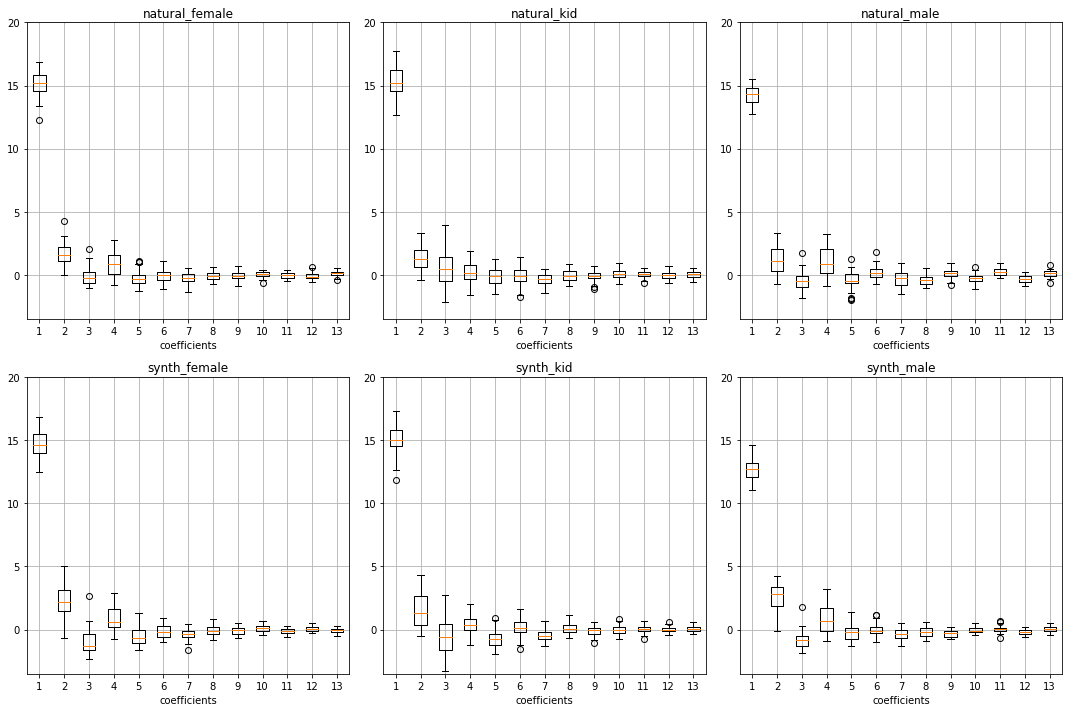

In [4]:
pl.figure(figsize=(15, 10))

NUM_PLOTS = len(FILES)
Y_MIN = -3.5
Y_MAX = 20
X_LABEL = 'coefficients'

for plot_index, s_class in enumerate(sorted(FILES.keys())):
    values = compute_mfcc(FILES[s_class])
    pl.subplot(2, 3, plot_index + 1)
    pl.ylim(Y_MIN, Y_MAX)
    pl.boxplot(values)
    pl.title(s_class)
    pl.xlabel(X_LABEL)
    pl.grid()
    
pl.tight_layout()

## MAN vs. WOMAN

Here we use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker.

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (`EPOCHS`) and number of hidden neurons (`N_NEURONS`).

In [5]:
N_INITS = 10
EPOCHS = 1000
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5
N_TRAIN_FILES = 20

dataset = create_dataset([('natural_male', -1), ('natural_female', 1)], N_TRAIN_FILES)
dataset_input = dataset[:, :-1]     # filter only input values (n-1 first values)
dataset_output = dataset[:, -1:]    # filter only the output class (last value)

print dataset

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 1], 'tanh')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

[[  1.33424814e+01   3.14850040e+00  -1.14895366e+00   2.57593294e-01
    2.91830590e-01   1.78755304e+00  -1.01323835e+00  -9.22539510e-01
    3.37675971e-01  -4.85621730e-01  -6.39462885e-02  -4.05242103e-01
   -9.25938250e-02  -1.00000000e+00]
 [  1.56965227e+01   1.49210707e+00   1.25776367e-01   9.92441142e-01
   -9.86305704e-01  -3.67082284e-01  -3.93531006e-01   5.16855474e-01
   -1.75918437e-01   2.04791011e-01   1.13463987e-01   4.64879016e-01
   -3.82776739e-01   1.00000000e+00]
 [  1.45486849e+01  -2.63109616e-02   1.37179793e+00   2.34299261e+00
   -1.61923057e-01   5.50889256e-01   5.44447546e-01  -6.85188408e-01
   -3.75370585e-01  -5.47894336e-03  -4.63566215e-01  -3.68752231e-01
    2.97925772e-01   1.00000000e+00]
 [  1.27716360e+01  -2.71337503e-01   1.76225015e+00   2.79815539e+00
   -3.00137913e-01   7.51086261e-01   6.59630053e-01  -3.45969704e-01
   -7.03949327e-02   1.21843362e-01   4.65715653e-02  -3.46104385e-01
    2.51991389e-01  -1.00000000e+00]
 [  1.382167

Then we plot the result :

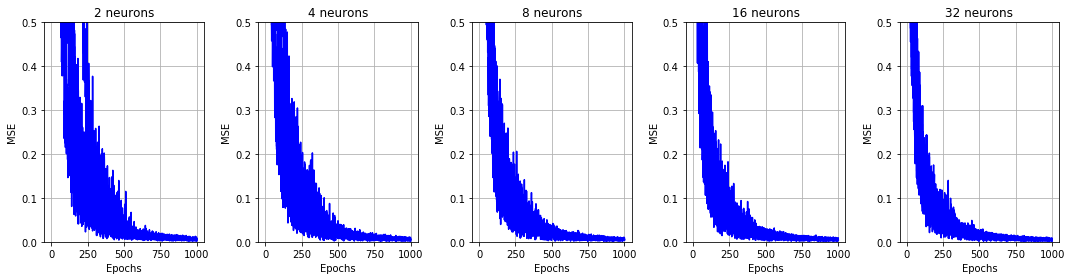

In [6]:
pl.figure(figsize=(15,4))

p_count = 0

for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)

    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    
    pl.ylim(0, 0.5)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()

pl.tight_layout()

In [7]:
EPOCHS = 500
K = 5

In [8]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))


dataset = []
for output, s_class in zip([-1, 1], ['natural_male', 'natural_female']):
    ceps = compute_mfcc(FILES[s_class])
    for input in ceps:
        dataset.append(np.append(input, output))

dataset = np.array(dataset)
np.random.shuffle(dataset)


for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


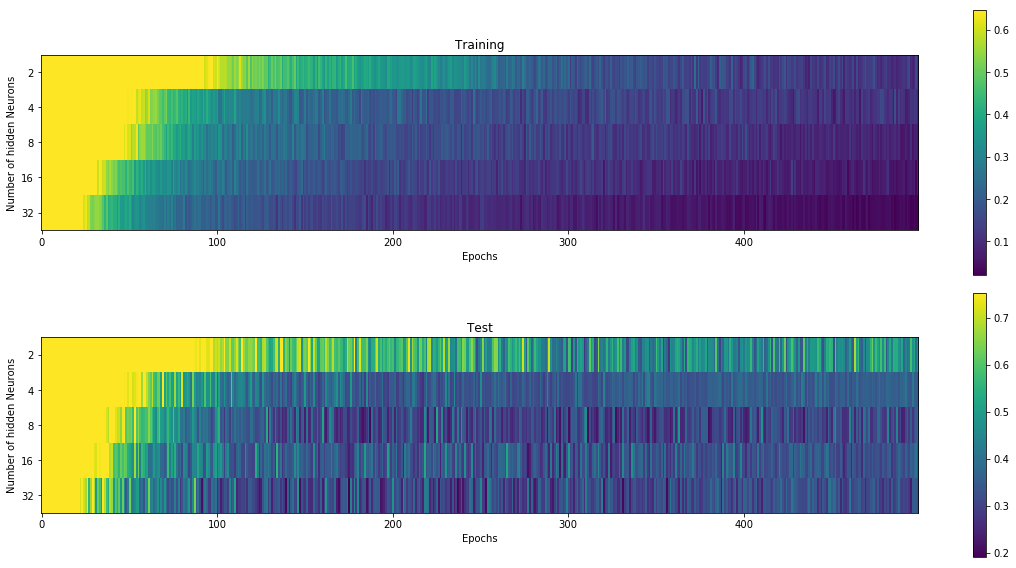

In [9]:
MAX_VAL = 90             # 100 is the maximum
pl.figure(figsize=(16, 8))
pl.subplot(2, 1, 1)
pl.imshow(MSE_train, vmin=np.min(MSE_train), vmax=np.percentile(MSE_train, 90), aspect=20, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2, 1, 2)
pl.imshow(MSE_test, vmin=np.min(MSE_test), vmax=np.percentile(MSE_test, 90), aspect=20, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### Final Model and performance

In [10]:
MOMENTUM = 0.5
EPOCHS = 1000
LEARNING_RATE = 0.001
N_NEURONS = 32

MSE training:  0.00772664765095
MSE test:  0.234889783681
Confusion matrix:
[[ 35.   1.]
 [  5.  31.]]


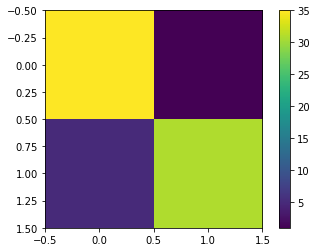

In [11]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=5,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)

print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat

# Man vs Children

In [14]:
N_INITS = 10
EPOCHS = 1000
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5
N_TRAIN_FILES = 20

dataset = create_dataset([('natural_male', -1), ('natural_kid', 1)], N_TRAIN_FILES)
dataset_input = dataset[:, :-1]     # filter only input values (n-1 first values)
dataset_output = dataset[:, -1:]    # filter only the output class (last value)

print dataset

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 1], 'tanh')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

[[  1.44341593e+01   8.60506315e-02   1.37121620e-01   2.59993245e+00
   -4.85791822e-01   3.91592732e-01  -4.91088095e-01   3.22287777e-01
   -8.21777291e-01  -2.42733022e-01  -1.60102002e-01  -3.35299375e-01
    2.39225590e-01  -1.00000000e+00]
 [  1.27716360e+01  -2.71337503e-01   1.76225015e+00   2.79815539e+00
   -3.00137913e-01   7.51086261e-01   6.59630053e-01  -3.45969704e-01
   -7.03949327e-02   1.21843362e-01   4.65715653e-02  -3.46104385e-01
    2.51991389e-01  -1.00000000e+00]
 [  1.42983840e+01   2.06479689e+00   1.59168893e+00  -7.40112424e-02
    3.69627065e-01  -8.44343995e-01  -2.56719592e-01  -4.69916930e-01
   -8.01227401e-01   9.46379550e-01  -4.12506203e-01   2.01818891e-01
    7.38390273e-02   1.00000000e+00]
 [  1.40862252e+01  -3.96348569e-02  -2.95864251e-01   2.39449465e+00
    3.73850973e-01  -3.95343300e-01  -7.24274170e-01   1.98288053e-01
    2.34690650e-01  -4.87879514e-01   9.95537342e-02  -3.15326722e-01
    1.66490564e-01  -1.00000000e+00]
 [  1.520541

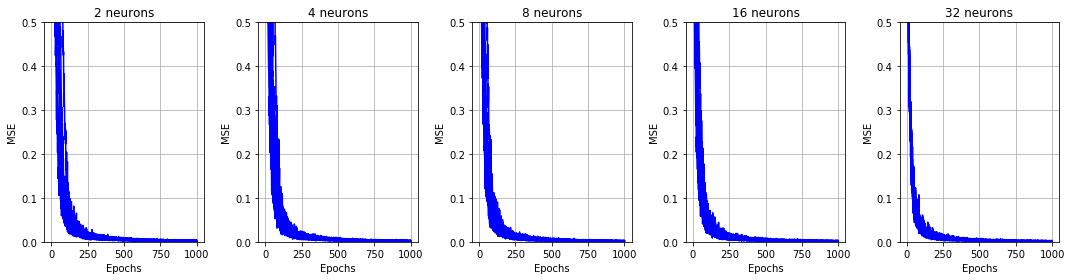

In [15]:
pl.figure(figsize=(15,4))

p_count = 0

for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)

    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    
    pl.ylim(0, 0.5)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()

pl.tight_layout()

The results here are rather good. The number of epochs drastically reflects on them, compared to the number of neurons. However, although the mean squared error average is low for every neuron sample from 250-500 epochs onward, the different iterations get more similar results when the number of neurons is raised.

In [16]:
EPOCHS = 500
K = 5

In [17]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))


dataset = []
for output, s_class in zip([-1, 1], ['natural_male', 'natural_kid']):
    ceps = compute_mfcc(FILES[s_class])
    for input in ceps:
        dataset.append(np.append(input, output))

dataset = np.array(dataset)
np.random.shuffle(dataset)


for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=MOMENTUM,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2
print 'Done'

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Done


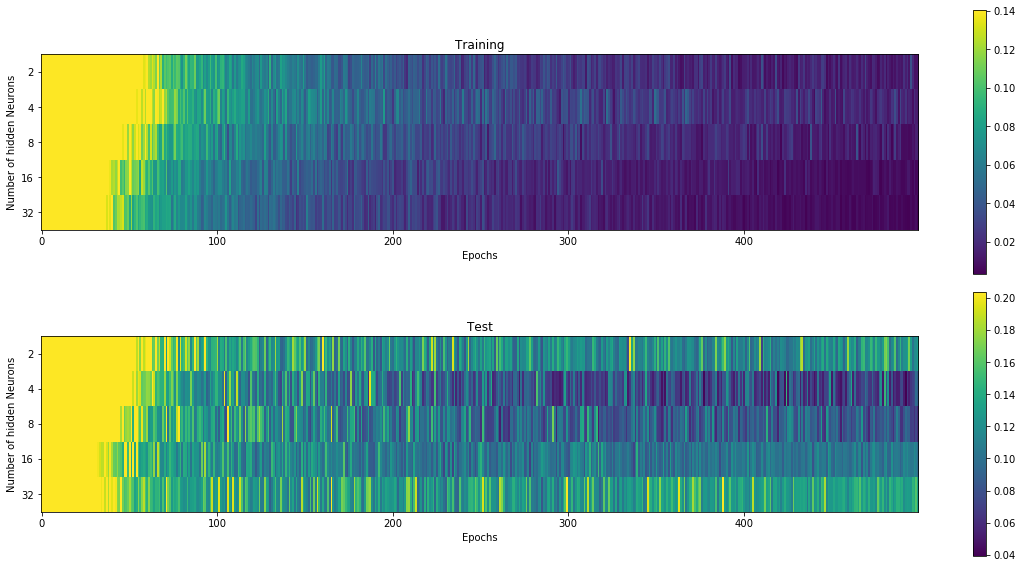

In [18]:
MAX_VAL = 90             # 100 is the maximum
pl.figure(figsize=(16, 8))
pl.subplot(2, 1, 1)
pl.imshow(MSE_train, vmin=np.min(MSE_train), vmax=np.percentile(MSE_train, 90), aspect=20, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2, 1, 2)
pl.imshow(MSE_test, vmin=np.min(MSE_test), vmax=np.percentile(MSE_test, 90), aspect=20, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### Final Model and performance

In [34]:
MOMENTUM = 0.37
EPOCHS = 1000
LEARNING_RATE = 0.005
N_NEURONS = 32

MSE training:  0.000205318752567
MSE test:  0.0640680017077
Confusion matrix:
[[ 107.    1.]
 [   2.   34.]]


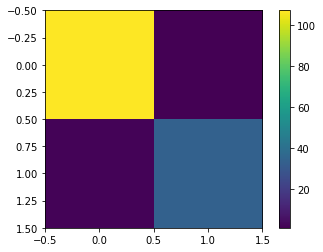

In [35]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=5,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)

print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat

Using a momentum value of 0.37, 1000 epochs, a learning rate of 0.005 and 32 neurons:

The class 1 results are 107 correct estimates and 1 incorrect one. The class 2 results are 2 incorrent estimates and 34 correct ones.